Libraries import

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
%matplotlib inline
from datetime import datetime
from datetime import date

Read the csv files

In [2]:
devices = pd.read_csv("data/devices.csv")
notifications = pd.read_csv("data/notifications.csv")
users = pd.read_csv("data/users.csv")
transactions = pd.read_csv("data/transactions_full.csv")

devices_test = pd.read_csv("data/devices_test.csv")
notifications_test = pd.read_csv("data/notifications_test.csv")
users_test = pd.read_csv("data/users_test.csv")
transactions_test = pd.read_csv("data/transactions_test.csv")

Dataset shapes

In [3]:
print("devices: ", devices.shape) 
print("notifications: ", notifications.shape) 
print("users: ", users.shape) 
print("transactions: ", transactions.shape)
print('----------------------------------')
print("devices_test: ", devices_test.shape) 
print("notifications_test: ", notifications_test.shape) 
print("users_test: ", users_test.shape) 
print("transactions_test: ", transactions_test.shape)

devices:  (15544, 2)
notifications:  (97704, 5)
users:  (15544, 12)
transactions:  (2181026, 12)
----------------------------------
devices_test:  (3886, 2)
notifications_test:  (23731, 5)
users_test:  (3886, 11)
transactions_test:  (536450, 12)


In [4]:
# calculate difference between dates

def days_between(d1, d2='2019-05-17'):
    d1 = str(pd.to_datetime(d1, dayfirst=True))[:10]
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

In [5]:
# change Unknown brand based on the rest

def change_unknown_brand(brand):
    if brand == 'Unknown':
        return random.sample(['Android', 'Apple'], 1)[0]
    else:
        return brand

Dataset modifications and creation of base data table

In [6]:
data = users.merge(devices)
data_test = users_test.merge(devices_test)

data['birth_year'] = data['birth_year'].apply(lambda x: 2020-x)
data_test['birth_year'] = data_test['birth_year'].apply(lambda x: 2020-x)

data['created_date'] = data['created_date'].apply(days_between)
data_test['created_date'] = data_test['created_date'].apply(days_between)

data = data.drop(columns = ['num_referrals','num_successful_referrals','country','city', 'attributes_notifications_marketing_push', 'attributes_notifications_marketing_email'])
data_test = data_test.drop(columns = ['num_referrals','num_successful_referrals','country','city', 'attributes_notifications_marketing_push', 'attributes_notifications_marketing_email'])

data = data.rename(columns={'birth_year':'age', 'created_date': 'reg_days', 'user_settings_crypto_unlocked':'crypto'})
data_test = data_test.rename(columns={'birth_year':'age', 'created_date': 'reg_days', 'user_settings_crypto_unlocked':'crypto'})

plan_dict = {'STANDARD': 0, 'SILVER': 1, 'GOLD': 1}
data['plan'] = data['plan'].replace(plan_dict)

data['brand'] = data['brand'].apply(change_unknown_brand)
data_test['brand'] = data_test['brand'].apply(change_unknown_brand)

data = pd.get_dummies(data, columns=['brand'])
data_test = pd.get_dummies(data_test,columns=['brand'])

In [7]:
data

,user_id,age,reg_days,crypto,plan,num_contacts,brand_Android,brand_Apple
0,user_0,28,249,0,0,3,0,1
1,user_1,35,491,1,0,75,0,1
2,user_2,24,169,0,0,71,0,1
3,user_3,39,454,0,0,219,0,1
4,user_4,28,494,0,0,0,0,1
...,...,...,...,...,...,...,...,...
15539,user_15539,23,285,0,0,0,1,0
15540,user_15540,35,414,0,0,0,0,1
15541,user_15541,42,308,0,0,16,1,0
15542,user_15542,43,495,0,1,44,0,1


In [8]:
users['num_successful_referrals'].value_counts() # All 0s

0    15544
Name: num_successful_referrals, dtype: int64

In [9]:
print(transactions['transactions_type'].value_counts())
print()
print(transactions_test['transactions_type'].value_counts())

# Cashback, Fee missing

CARD_PAYMENT    1173661
TRANSFER         402126
TOPUP            309740
EXCHANGE         124800
ATM               74181
CASHBACK          65063
FEE               18786
CARD_REFUND        9209
TAX                2267
REFUND             1193
Name: transactions_type, dtype: int64

CARD_PAYMENT    302119
TRANSFER         98283
TOPUP            78591
EXCHANGE         34348
ATM              19494
CARD_REFUND       2753
TAX                562
REFUND             300
Name: transactions_type, dtype: int64


In [10]:
notifications_test['reason'].value_counts() # Silver missing

REENGAGEMENT_ACTIVE_FUNDS            7012
PROMO                                4756
NO_INITIAL_CARD_USE                  2186
NO_INITIAL_CARD_ORDER                2065
INVEST_IN_GOLD                       1724
LOST_CARD_ORDER                      1205
PROMO_CARD_ORDER                     1101
JOINING_ANNIVERSARY                   824
ONBOARDING_TIPS_ACTIVATED_USERS       722
MADE_MONEY_REQUEST_NOT_SPLIT_BILL     655
ENGAGEMENT_SPLIT_BILL_RESTAURANT      464
BLACK_FRIDAY                          428
METAL_RESERVE_PLAN                    283
WELCOME_BACK                          171
BLUE_TUESDAY                          135
Name: reason, dtype: int64

In [11]:
devices_test['brand'].value_counts()

Apple      1961
Android    1914
Unknown      11
Name: brand, dtype: int64

<AxesSubplot:>

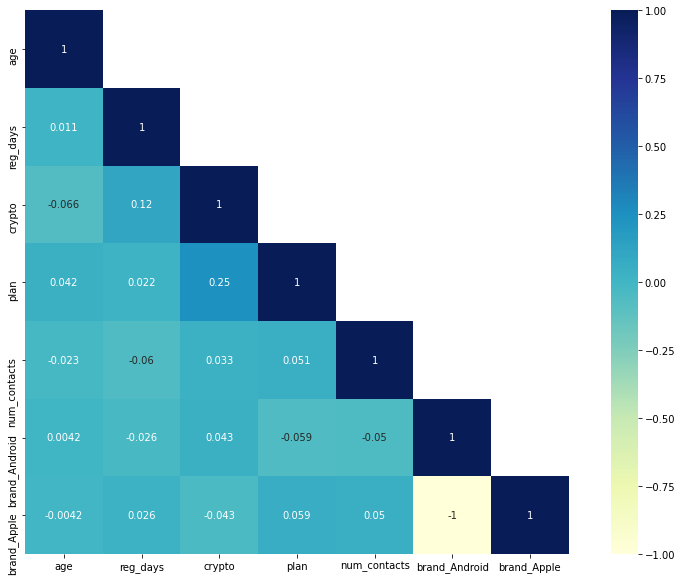

In [12]:
data_corr = data[['age','reg_days','crypto','plan','num_contacts','brand_Android','brand_Apple']].corr()
mask = np.array(data_corr)
mask[np.tril_indices_from(mask)] = False
fig = plt.subplots(figsize=(15, 10))
sns.heatmap(data_corr, mask=mask, vmax=1, square=True, annot=True, cmap="YlGnBu")

Notifications table modification

In [13]:
notifications = notifications[['status','user_id']]
notifications_test = notifications_test[['status','user_id']]

notifications = notifications[~notifications['status'].isin(['FAILED'])]
notifications_test = notifications_test[~notifications_test['status'].isin(['FAILED'])]

notifications.drop(columns='status',inplace=True)
notifications_test.drop(columns='status',inplace=True)

notifications = notifications['user_id'].value_counts().rename_axis('user_id').reset_index(name='notif_counts')
notifications_test = notifications_test['user_id'].value_counts().rename_axis('user_id').reset_index(name='notif_counts')

In [14]:
notifications

,user_id,notif_counts
0,user_5529,20
1,user_5744,20
2,user_9196,17
3,user_8951,17
4,user_6038,17
...,...,...
14735,user_6177,1
14736,user_11945,1
14737,user_4660,1
14738,user_5815,1


Transactions table modification

In [15]:
transactions = transactions[['user_id','amount_usd','transactions_state','direction', 'transactions_type']]
transactions_test = transactions_test[['user_id','amount_usd','transactions_state','direction', 'transactions_type']]

transactions = transactions[transactions['transactions_state'].isin(['COMPLETED'])]
transactions_test = transactions_test[transactions_test['transactions_state'].isin(['COMPLETED'])]

In [16]:
t1 = transactions.pivot_table(index='user_id', columns='transactions_type',aggfunc='size', fill_value=0)
t1_test = transactions_test.pivot_table(index='user_id', columns='transactions_type',aggfunc='size', fill_value=0)

t1

transactions_type,ATM,CARD_PAYMENT,CARD_REFUND,CASHBACK,EXCHANGE,FEE,REFUND,TAX,TOPUP,TRANSFER
user_id,,,,,,,,,,
user_0,0,333,1,0,5,0,0,0,158,23
user_1,4,78,0,0,0,0,0,0,24,27
user_10,3,42,9,0,3,0,0,0,43,23
user_100,6,38,0,0,0,0,0,0,11,0
user_1000,1,16,0,16,0,2,0,0,7,1
...,...,...,...,...,...,...,...,...,...,...
user_9995,0,2,0,0,1,0,0,0,1,0
user_9996,1,20,0,0,5,1,0,0,4,0
user_9997,3,49,1,0,20,1,0,0,30,24


In [17]:
t2 = transactions.groupby(by=['user_id', 'direction'], as_index=False)['amount_usd'].sum()
t2_test = transactions_test.groupby(by=['user_id', 'direction'], as_index=False)['amount_usd'].sum()

t2 = t2.pivot(index='user_id', columns='direction', values='amount_usd')
t2_test = t2_test.pivot(index='user_id', columns='direction', values='amount_usd')

t2

direction,INBOUND,OUTBOUND
user_id,,
user_0,3295.33,3629.75
user_1,6465.51,6490.03
user_10,2750.01,2688.91
user_100,2119.16,2110.94
user_1000,429.20,413.92
...,...,...
user_9995,52.49,187.36
user_9996,680.00,1001.76
user_9997,3338.02,4312.51


In [18]:
t1['user_id'] = t1.index
t1_test['user_id'] = t1_test.index
t2['user_id'] = t2.index
t2_test['user_id'] = t2_test.index

t1.reset_index(drop=True, inplace=True)
t1_test.reset_index(drop = True, inplace=True)
t2.reset_index(drop=True, inplace=True)
t2_test.reset_index(drop=True, inplace=True)

In [19]:
transactions = t1.merge(t2, on = 'user_id')
transactions_test = t1_test.merge(t2_test, on = 'user_id')

transactions = transactions.drop(columns=['CASHBACK','FEE'])

In [20]:
data = data.set_index('user_id').join(transactions.set_index('user_id'))
data['user_id'] = data.index
data.reset_index(drop=True, inplace=True)
data = data.set_index('user_id').join(notifications.set_index('user_id'))

data_test = data_test.set_index('user_id').join(transactions_test.set_index('user_id'))
data_test['user_id'] = data_test.index
data_test.reset_index(drop=True, inplace=True)
data_test = data_test.set_index('user_id').join(notifications_test.set_index('user_id'))

In [21]:
data.fillna(0, inplace=True)
data_test.fillna(0, inplace= True)

In [22]:
data

,age,reg_days,crypto,plan,num_contacts,brand_Android,brand_Apple,ATM,CARD_PAYMENT,CARD_REFUND,EXCHANGE,REFUND,TAX,TOPUP,TRANSFER,INBOUND,OUTBOUND,notif_counts
user_id,,,,,,,,,,,,,,,,,,
user_0,28,249,0,0,3,0,1,0.0,333.0,1.0,5.0,0.0,0.0,158.0,23.0,3295.33,3629.75,8.0
user_1,35,491,1,0,75,0,1,4.0,78.0,0.0,0.0,0.0,0.0,24.0,27.0,6465.51,6490.03,10.0
user_2,24,169,0,0,71,0,1,0.0,97.0,0.0,0.0,0.0,0.0,37.0,134.0,1171.06,1552.84,5.0
user_3,39,454,0,0,219,0,1,0.0,120.0,0.0,0.0,0.0,0.0,13.0,7.0,3472.34,3526.95,6.0
user_4,28,494,0,0,0,0,1,0.0,37.0,1.0,4.0,0.0,0.0,8.0,0.0,420.06,561.37,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
user_15539,23,285,0,0,0,1,0,1.0,42.0,1.0,13.0,0.0,0.0,32.0,1.0,1700.32,2574.63,3.0
user_15540,35,414,0,0,0,0,1,0.0,4.0,1.0,0.0,0.0,0.0,3.0,1.0,48.55,48.55,0.0
user_15541,42,308,0,0,16,1,0,0.0,534.0,0.0,5.0,0.0,0.0,77.0,445.0,8858.65,8863.01,4.0


### Machine Learning Algorithms

In [23]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['plan']).values
y = data['plan'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [24]:
from sklearn.feature_selection import VarianceThreshold

var = VarianceThreshold()

In [25]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

In [26]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

sampler = SMOTE()

In [27]:
X_columns = data.drop(columns=['plan']).columns

In [28]:
rf = RandomForestClassifier(n_estimators=250, n_jobs=-1)
rf.fit(X_train, y_train)
rf.feature_importances_

array([0.06756789, 0.08479254, 0.04750746, 0.05951747, 0.01118078,
       0.01086813, 0.06005225, 0.0797716 , 0.02082246, 0.04686302,
       0.03488253, 0.00511034, 0.06760735, 0.06520155, 0.13856174,
       0.1358059 , 0.06388699])

In [29]:
for c, imp in sorted(zip(X_columns, rf.feature_importances_), key=lambda pair: pair[1], reverse=True):
  print('{:20}: {}'.format(c, imp))

INBOUND             : 0.138561735992858
OUTBOUND            : 0.13580590226945125
reg_days            : 0.08479253564563723
CARD_PAYMENT        : 0.07977160183594606
TOPUP               : 0.06760735438494288
age                 : 0.06756788709006531
TRANSFER            : 0.0652015466324367
notif_counts        : 0.06388698749498474
ATM                 : 0.060052249275179735
num_contacts        : 0.059517472219801616
crypto              : 0.047507457814747724
EXCHANGE            : 0.04686302423351264
REFUND              : 0.03488253170118606
CARD_REFUND         : 0.02082246379483067
brand_Android       : 0.01118078415962284
brand_Apple         : 0.010868127653195725
TAX                 : 0.005110337801600883


In [32]:
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


#rf = QuadraticDiscriminantAnalysis()
#rf = GradientBoostingClassifier()
rf = RandomForestClassifier()
#rf = LogisticRegression()
#rf = MLPClassifier()


pipe1 = Pipeline([('scaler', sc),
                  ('selector', var),
                  ('sampler', sampler),
                  ('model', rf)])


'''
grid1 = {'model__hidden_layer_sizes': [(1024,256,1024,256)],
         'model__activation': ["relu"]}
'''

'''
grid1= {'selector__threshold': [0.2],
        'model__tol': [0.001],
        'model__class_weight':[{1: w} for w in [1]], #Logistic Regression
        'model__solver':['liblinear'],
        'model__multi_class':['auto'],
        'model__penalty': ['l1', 'l2', 'elasticnet'],
        'model__max_iter': [100, 200,]}
'''


grid1 = {'selector__threshold': [0.8],   
         'model__n_estimators': [300],
         'model__criterion': ['entropy'],
         'model__class_weight': ['balanced']}  #Random Forest


'''
grid1 = {'selector__threshold': [0.4, 0.8],
         'model__learning_rate': [1, 0.1, 0.01],
         'model__n_estimators': [100, 200, 300],
         'model__criterion': ['friedman_mse', 'mse', 'mae'],
         'model__max_depth': [3, 5, 7]}
'''
    
#cv=[(slice(None), slice(None))]
clf = GridSearchCV(pipe1, grid1, scoring='f1_macro', verbose = 3, n_jobs = -1, cv = 5)
clf.fit(X_train, y_train)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selector', VarianceThreshold()),
                                       ('sampler', SMOTE()),
                                       ('model', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'model__class_weight': ['balanced'],
                         'model__criterion': ['entropy'],
                         'model__n_estimators': [300],
                         'selector__threshold': [0.8]},
             scoring='f1_macro', verbose=3)

In [39]:
from sklearn.metrics import classification_report
print(clf.best_params_, '\n')

preds = clf.predict(X_test)
clr = classification_report(y_test, preds)
print(clr)
result = clf.predict(data_test)


{'model__class_weight': 'balanced', 'model__criterion': 'entropy', 'model__n_estimators': 300, 'selector__threshold': 0.8} 

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1440
           1       0.45      0.47      0.46       115

    accuracy                           0.92      1555
   macro avg       0.70      0.71      0.71      1555
weighted avg       0.92      0.92      0.92      1555



<AxesSubplot:>

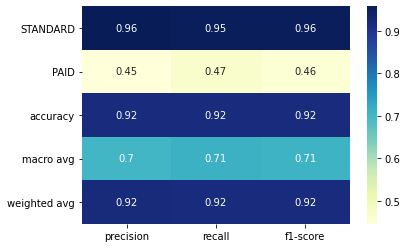

In [50]:
true = y_test
pred = preds
labels = np.arange(2)
target_names = ['STANDARD', 'PAID']

clf_report = classification_report(true,
                                   pred,
                                   labels=labels,
                                   target_names=target_names,
                                   output_dict=True)

# .iloc[:-1, :] to exclude support
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="YlGnBu")

In [51]:
pd.Series(result)

0       0
1       0
2       0
3       0
4       0
       ..
3881    1
3882    1
3883    0
3884    1
3885    0
Length: 3886, dtype: int64

In [52]:
predictions = data_test.reset_index()['user_id']
predictions = pd.concat([predictions,pd.Series(result)], axis =1)
predictions.rename(columns ={0: 'pred'}, inplace = True)
predictions.to_csv("data/test_preds.csv")
predictions

,user_id,pred
0,user_2,0
1,user_8,0
2,user_10,0
3,user_13,0
4,user_17,0
...,...,...
3881,user_18748,1
3882,user_18788,1
3883,user_18904,0
3884,user_19194,1
